## Device maintenance Task
Given a data set containing data collected from sensors that are monitoring a  
certain device a stakeholder perceived the need to improve the maintenance  
of this device.  


He approached you and described the Business case as:  
We have this data and I understand that we need to improve the way we  
schedule the maintenance for this device, can you assess this data and create  
an AI solution for it?  


The data is composed of 53 features and 1 Class.  
One of the features is a timestamp, the others are sensor observations.  
Can you help me to improve the maintenance somehow?  
You should prepare the code and a short presentation (10 minutes max)  
explaining your approach and why you decided to use the chosen approach.  

### Deliverables:
Code in an exported notebook  
Presentation

In [ ]:
# !pip install -q -U umap-learn
# !pip install imbalanced-learn

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
import random
import json
from tqdm.notebook import tqdm
import utils
pd.set_option('display.max_rows', 60)

In [45]:
df = pd.read_csv('data/DATA.csv', index_col=0)
print(df.shape)
df.head()

(220320, 54)


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [46]:
df.isnull().sum().sort_values(ascending=False)

sensor_15         220320
sensor_50          77017
sensor_51          15383
sensor_00          10208
sensor_07           5451
sensor_08           5107
sensor_06           4798
sensor_09           4595
sensor_01            369
sensor_30            261
sensor_29             72
sensor_32             68
sensor_18             46
sensor_17             46
sensor_22             41
sensor_25             36
sensor_16             31
sensor_49             27
sensor_48             27
sensor_47             27
sensor_46             27
sensor_45             27
sensor_44             27
sensor_43             27
sensor_42             27
sensor_41             27
sensor_40             27
sensor_39             27
sensor_38             27
sensor_14             21
sensor_26             20
sensor_03             19
sensor_10             19
sensor_13             19
sensor_12             19
sensor_11             19
sensor_05             19
sensor_04             19
sensor_02             19
sensor_36             16


In [47]:
# Drop empty column
df.drop(["sensor_15"], axis = 1, inplace = True)

In [48]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df.set_index('timestamp', inplace=True)

In [49]:
cols = df.columns[:-1]
print(len(cols), cols)

51 Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51'],
      dtype='object')


# Target variable
Data is highly imbalanced.

We store in preprocessing.json the threshold we use to clip the values and remove the extreme outliers.  
This is done to ensure if new data is available for testing the model, the processing produces similar values.

In [50]:
df["machine_status"].value_counts()

machine_status
NORMAL         205836
MAINTENANCE     14477
BROKEN              7
Name: count, dtype: int64

In [51]:
meta={"features":{}, "target":{"BROKEN": 0, "NORMAL": 1, "MAINTENANCE": 2}}
for c in cols:
    meta["features"][c] = {"min": df[c].quantile(0.01), "max": df[c].quantile(0.99)}

# Assuming data is your Python object
with open('preprocessing.json', 'w') as f:
    json.dump(meta, f)



# Preprocessing
Clip outlier values + min/max scaling

In [52]:
df, cols = utils.preprocess(df)

# Visualize dataset

Text(0.5, 1.0, 'PCA plot')

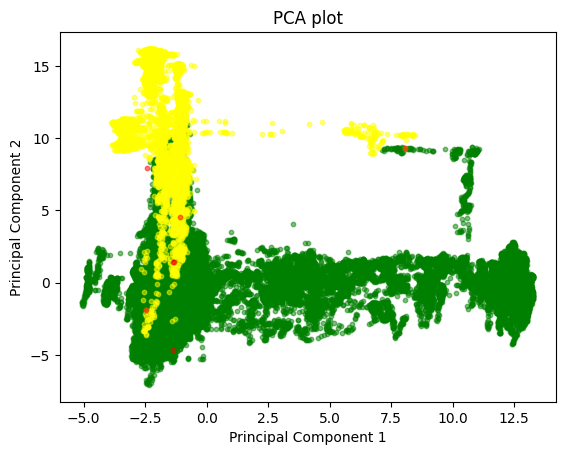

In [53]:
from sklearn.decomposition import PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[cols].values)
# Perform PCA
pca = PCA(n_components=2)  # Adjust as needed
embedding = pca.fit_transform(scaled_data)
ii = np.where(df['y'].values == 1)[0]
plt.scatter(embedding[ii, 0], embedding[ii, 1], c="green", s=10, alpha=0.5, label = "maintenance")

ii = np.where(df['y'].values == 2)[0]
plt.scatter(embedding[ii, 0], embedding[ii, 1], c="yellow", s=10, alpha=0.5, label = "normal")


ii = np.where(df['y'].values == 0)[0]
plt.scatter(embedding[ii, 0], embedding[ii, 1], c="red", s=10, alpha=0.5, label = "broken")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA plot')

# Filtering
Remove maintenance and last normal period


In [54]:
df = df[df["machine_status"] != "MAINTENANCE"]
print(df.shape)

(205843, 54)


In [55]:
df = df[df['idx'] <= df[df["machine_status"] == "BROKEN"]["idx"].values[-1]]
print(df.shape)
df['idx'] = np.arange(df.shape[0])

(152039, 54)


### Plotting sensors behavior close to failure

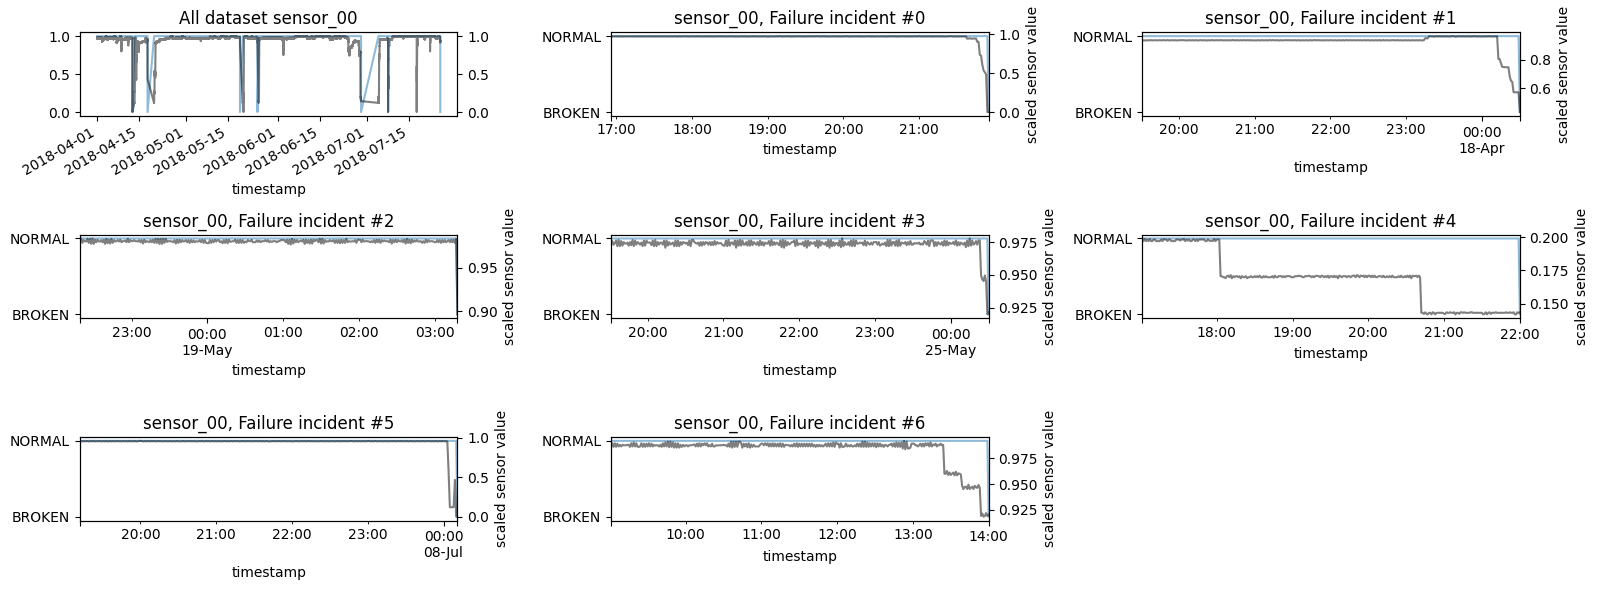

In [56]:
c = "sensor_00"
broken_idx = df[df['y'] == 0]['idx'].values
eta = 300
plt.figure(figsize=(16, 6))
ax = plt.subplot(3, 3, 1)
df['y'].plot(alpha = 0.5)
ax.twinx()
plt.title(f"All dataset {c}")
df[c].plot(alpha = 0.5, c = 'black')
for i in range(len(broken_idx)):
    broken_id = broken_idx[i]
    ax = plt.subplot(3, 3, i+2)
    df[(df['idx'] > broken_id - eta) & (df['idx'] <= broken_id)]['y'].plot(alpha = 0.5)
    plt.yticks(ticks=[0, 1], labels=["BROKEN", "NORMAL"])
    # df[(df['idx'] > broken_id - eta) & (df['idx'] <= broken_id )][f"z_{c}"].plot(alpha = 0.5, c = 'red',style = '--')
    # df[(df['idx'] > broken_id - eta) & (df['idx'] <= broken_id )][f"maxz_{c}"].plot(alpha = 0.5, c = 'green',style = '--')
    ax.twinx()
    plt.title(f"{c}, Failure incident #{i}")
    df[(df['idx'] > broken_id - eta) & (df['idx'] <= broken_id )][c].plot(alpha = 0.5, c = 'black')
    plt.ylabel('scaled sensor value')
    
plt.tight_layout()

In [57]:
# Feature engineering extra columns
# cols = cols[[0,4,5,6,7,8,9]]
# extra_cols = []
# for c in cols:
#     df[f'rm{c}'] = df[f'{c}'].rolling(window=100, min_periods = 1).mean()
#     df[f'shifted{c}'] = df[f'rm{c}'].shift(100)
#     extra_cols.append(f'rm{c}')
#     extra_cols.append(f'shifted{c}')

# cols = np.concatenate([cols, extra_cols])
# print(cols)

# Create survival columns
survival column holds the timestep to failure   
incident_nb holds the index of the incident (e.g. 0-6)

In [58]:
prev = 0
survival = np.zeros(df.shape[0])
incident = np.zeros(df.shape[0])
broken_idx = df[df['y'] == 0]['idx'].values
for ii, i in enumerate(broken_idx):
    survival[prev:i+1] = np.arange(i-prev+1)[::-1]
    incident[prev:i+1] = np.ones(i-prev+1) * ii
    prev = i + 1
df['survival'] = survival.astype(int)
df['incident_nb'] = incident.astype(int)

In [59]:
df['incident_nb'].value_counts()

incident_nb
4    49645
2    41698
6    25268
0    17156
3     7160
1     6411
5     4701
Name: count, dtype: int64

# Dataset creation for training

In [ ]:
df.set_index(np.arange(len(df)), inplace = True)

The code below has been moved to utils.py

In [ ]:
window_size = 2 # nb of timesteps in each sample
horizon = 50000
X = []
y_reg = []
incident_ref = []
idx_ref = []

In [ ]:
# exclude idx to ensure we have non overlapping sliding windows across failures (e.g. addind samples from failure k-1 to failure k)
exclude_idx = []
last_samples = df.groupby("incident_nb").agg({"idx":"min"}).values.reshape(-1)
for _ in range(window_size - 1):
    exclude_idx.append(last_samples)
    last_samples = last_samples+1
if len(exclude_idx)>0:
    exclude_idx = np.concatenate(exclude_idx)
print(len(exclude_idx))

In [ ]:
# choose ids for the samples in the dataset that can have a non overlapping size of window_size and are spaced by 100 timesteps
idx = df[(df["survival"] <= horizon) & 
         (df["survival"]%window_size ==0)& 
         (df["survival"]%100 ==0)  & 
         (~df["idx"].isin(exclude_idx))]["idx"].values
for window in range(window_size):
    df_= df[df["idx"].isin(idx)].sort_values(by = "idx", ascending = True)
    X.append(df_[cols].values)
    if window == 0:
        y_reg = df_["survival"].values
        incident_ref = df_["incident_nb"].values
        idx_ref = df_["idx"].values
    idx = idx -1

In [ ]:
prediction_horizon = 300
df["y_temp"] = (df["survival"]<prediction_horizon).astype(int)

X = np.array(X).transpose(1,2,0)
y_reg = np.array(y_reg)
incident_ref = np.array(incident_ref)
idx_ref = np.array(idx_ref)
y_classif = df.iloc[idx_ref]["y_temp"].values
print(X.shape, y_reg.shape, Counter(y_classif))
